<a href="https://colab.research.google.com/github/Starry-Curry/NLPLearning/blob/main/chapter_natural-language-processing-pretraining/bert-pretraining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [3]:
!pip install git+https://github.com/d2l-ai/d2l-zh@release --no-deps  # installing d2l

  Cloning https://github.com/d2l-ai/d2l-zh (to revision release) to /tmp/pip-req-build-k9owee5y
  Running command git clone --filter=blob:none --quiet https://github.com/d2l-ai/d2l-zh /tmp/pip-req-build-k9owee5y
  Running command git checkout -b release --track origin/release
  Switched to a new branch 'release'
  Branch 'release' set up to track remote branch 'release' from 'origin'.
  Resolved https://github.com/d2l-ai/d2l-zh to commit 843d3d41dca48d8df65f4b324dd171d8bfe9c067
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... done
  Created wheel for d2l: filename=d2l-2.0.0-py3-none-any.whl size=110800 sha256=7f546022e87be4cef49ae2ce394adc9f0879b2fc0c8e1e867625a1b1db0222c8
  Stored in directory: /tmp/pip-ephem-wheel-cache-8eoifkqn/wheels/3e/87/36/53b013ece7da539a59fcc56da2d329d7afb08eef9a9a5ae1d1
Successfully built d2l


# 预训练BERT
:label:`sec_bert-pretraining`

利用 :numref:`sec_bert`中实现的BERT模型和 :numref:`sec_bert-dataset`中从WikiText-2数据集生成的预训练样本，我们将在本节中在WikiText-2数据集上对BERT进行预训练。


In [4]:
import torch
from torch import nn
from d2l import torch as d2l

首先，我们加载WikiText-2数据集作为小批量的预训练样本，用于遮蔽语言模型和下一句预测。批量大小是512，BERT输入序列的最大长度是64。注意，在原始BERT模型中，最大长度是512。


In [7]:
from torch.utils.data import DataLoader, TensorDataset
from datasets import load_dataset
import random

def load_data_wiki_fixed(batch_size=512, num_steps=64, max_len=64):
    """
    加载 Hugging Face wikitext-2-v1，并生成适用于 BERT 预训练（MLM + NSP）的数据迭代器
    返回: (train_iter, vocab)
    """
    # 1. 加载 wikitext-2 数据
    dataset = load_dataset("Salesforce/wikitext", "wikitext-2-v1")
    paragraphs = []
    for split in ["train", "validation", "test"]:
        for text in dataset[split]["text"]:
            if text.strip():
                paragraphs.append(text.strip())

    # 2. 构建词表
    sentences = [s.split() for s in paragraphs]
    vocab = d2l.Vocab(sentences, min_freq=2)

    # 3. 辅助函数：生成句子对（NSP）
    def get_sentence_pairs(sentences):
        """生成 (sentence_a, sentence_b, is_next) 列表"""
        pairs = []
        for i in range(len(sentences) - 1):
            if random.random() < 0.5:  # 正样本（下一句）
                pairs.append((sentences[i], sentences[i + 1], 1))
            else:  # 负样本（随机句子）
                rand_idx = random.randint(0, len(sentences) - 1)
                pairs.append((sentences[i], sentences[rand_idx], 0))
        return pairs

    sentence_pairs = get_sentence_pairs(paragraphs)

    # 4. 随机 Mask 函数（MLM）
    def random_mask(tokens, vocab):
        """对 tokens 进行随机掩码 (15%)，返回 (被mask后的tokens, 预测位置, 预测标签)"""
        cand_idx = [i for i, token in enumerate(tokens)
                    if token not in ['[CLS]', '[SEP]']]
        num_to_mask = max(1, round(len(cand_idx) * 0.15))
        pred_positions, pred_labels = [], []
        for idx in random.sample(cand_idx, num_to_mask):
            pred_positions.append(idx)
            pred_labels.append(tokens[idx])
            # 80% mask, 10% random, 10% unchanged
            if random.random() < 0.8:
                tokens[idx] = '[MASK]'
            elif random.random() < 0.5:
                tokens[idx] = random.choice(list(vocab.token_to_idx.keys()))
        return tokens, pred_positions, pred_labels

    # 5. 将句子对编码为BERT输入
    all_data = []
    for a, b, is_next in sentence_pairs:
        tokens_a = ['[CLS]'] + a.split() + ['[SEP]']
        tokens_b = b.split() + ['[SEP]']
        tokens = tokens_a + tokens_b
        segments = [0] * len(tokens_a) + [1] * len(tokens_b)
        if len(tokens) > max_len:
            tokens = tokens[:max_len]
            segments = segments[:max_len]
        # mask
        tokens, pred_pos, pred_labels = random_mask(tokens, vocab)
        token_ids = vocab[tokens]
        valid_len = len(token_ids)
        pred_labels = vocab[pred_labels]
        mlm_weights = [1.0] * len(pred_labels)

        all_data.append((
            token_ids, segments, valid_len, pred_pos, mlm_weights, pred_labels, is_next
        ))

    # 6. Padding 并转成 Tensor
    def pad_bert_inputs(examples):
        max_len_tokens = max(len(x[0]) for x in examples)
        max_num_mlm_preds = max(len(x[3]) for x in examples)
        tokens_X, segments_X, valid_lens_x = [], [], []
        pred_positions_X, mlm_weights_X, mlm_Y, nsp_y = [], [], [], []

        for token_ids, seg, vlen, ppos, mw, my, nsp in examples:
            tokens_X.append(d2l.truncate_pad(token_ids, max_len_tokens, vocab['[PAD]']))
            segments_X.append(d2l.truncate_pad(seg, max_len_tokens, 0))
            valid_lens_x.append(vlen)
            pred_positions_X.append(d2l.truncate_pad(ppos, max_num_mlm_preds, 0))
            mlm_weights_X.append(d2l.truncate_pad(mw, max_num_mlm_preds, 0))
            mlm_Y.append(d2l.truncate_pad(my, max_num_mlm_preds, 0))
            nsp_y.append(nsp)

        return (torch.tensor(tokens_X), torch.tensor(segments_X),
                torch.tensor(valid_lens_x), torch.tensor(pred_positions_X),
                torch.tensor(mlm_weights_X), torch.tensor(mlm_Y),
                torch.tensor(nsp_y))

    # 小样本快速训练
    random.shuffle(all_data)
    all_data = all_data[:5000]  # 可以改大，完整训练可用 >100k
    data = pad_bert_inputs(all_data)

    # 7. 构造 DataLoader
    dataset = TensorDataset(*data)
    train_iter = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    return train_iter, vocab


# ✅ 使用
train_iter, vocab = load_data_wiki_fixed(batch_size=512, num_steps=64)
print("Vocab size:", len(vocab))


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

wikitext-2-v1/test-00000-of-00001.parque(…):   0%|          | 0.00/685k [00:00<?, ?B/s]

wikitext-2-v1/train-00000-of-00001.parqu(…):   0%|          | 0.00/6.07M [00:00<?, ?B/s]

wikitext-2-v1/validation-00000-of-00001.(…):   0%|          | 0.00/618k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

Vocab size: 33277


## 预训练BERT

原始BERT :cite:`Devlin.Chang.Lee.ea.2018`有两个不同模型尺寸的版本。基本模型（$\text{BERT}_{\text{BASE}}$）使用12层（Transformer编码器块），768个隐藏单元（隐藏大小）和12个自注意头。大模型（$\text{BERT}_{\text{LARGE}}$）使用24层，1024个隐藏单元和16个自注意头。值得注意的是，前者有1.1亿个参数，后者有3.4亿个参数。为了便于演示，我们定义了一个小的BERT，使用了2层、128个隐藏单元和2个自注意头。


In [8]:
net = d2l.BERTModel(len(vocab), num_hiddens=128, norm_shape=[128],
                    ffn_num_input=128, ffn_num_hiddens=256, num_heads=2,
                    num_layers=2, dropout=0.2, key_size=128, query_size=128,
                    value_size=128, hid_in_features=128, mlm_in_features=128,
                    nsp_in_features=128)
devices = d2l.try_all_gpus()
loss = nn.CrossEntropyLoss()

在定义训练代码实现之前，我们定义了一个辅助函数`_get_batch_loss_bert`。给定训练样本，该函数计算遮蔽语言模型和下一句子预测任务的损失。请注意，BERT预训练的最终损失是遮蔽语言模型损失和下一句预测损失的和。


In [9]:
#@save
def _get_batch_loss_bert(net, loss, vocab_size, tokens_X,
                         segments_X, valid_lens_x,
                         pred_positions_X, mlm_weights_X,
                         mlm_Y, nsp_y):
    # 前向传播
    _, mlm_Y_hat, nsp_Y_hat = net(tokens_X, segments_X,
                                  valid_lens_x.reshape(-1),
                                  pred_positions_X)
    # 计算遮蔽语言模型损失
    mlm_l = loss(mlm_Y_hat.reshape(-1, vocab_size), mlm_Y.reshape(-1)) *\
    mlm_weights_X.reshape(-1, 1)
    mlm_l = mlm_l.sum() / (mlm_weights_X.sum() + 1e-8)
    # 计算下一句子预测任务的损失
    nsp_l = loss(nsp_Y_hat, nsp_y)
    l = mlm_l + nsp_l
    return mlm_l, nsp_l, l

通过调用上述两个辅助函数，下面的`train_bert`函数定义了在WikiText-2（`train_iter`）数据集上预训练BERT（`net`）的过程。训练BERT可能需要很长时间。以下函数的输入`num_steps`指定了训练的迭代步数，而不是像`train_ch13`函数那样指定训练的轮数（参见 :numref:`sec_image_augmentation`）。


In [10]:
def train_bert(train_iter, net, loss, vocab_size, devices, num_steps):
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    trainer = torch.optim.Adam(net.parameters(), lr=0.01)
    step, timer = 0, d2l.Timer()
    animator = d2l.Animator(xlabel='step', ylabel='loss',
                            xlim=[1, num_steps], legend=['mlm', 'nsp'])
    # 遮蔽语言模型损失的和，下一句预测任务损失的和，句子对的数量，计数
    metric = d2l.Accumulator(4)
    num_steps_reached = False
    while step < num_steps and not num_steps_reached:
        for tokens_X, segments_X, valid_lens_x, pred_positions_X,\
            mlm_weights_X, mlm_Y, nsp_y in train_iter:
            tokens_X = tokens_X.to(devices[0])
            segments_X = segments_X.to(devices[0])
            valid_lens_x = valid_lens_x.to(devices[0])
            pred_positions_X = pred_positions_X.to(devices[0])
            mlm_weights_X = mlm_weights_X.to(devices[0])
            mlm_Y, nsp_y = mlm_Y.to(devices[0]), nsp_y.to(devices[0])
            trainer.zero_grad()
            timer.start()
            mlm_l, nsp_l, l = _get_batch_loss_bert(
                net, loss, vocab_size, tokens_X, segments_X, valid_lens_x,
                pred_positions_X, mlm_weights_X, mlm_Y, nsp_y)
            l.backward()
            trainer.step()
            metric.add(mlm_l, nsp_l, tokens_X.shape[0], 1)
            timer.stop()
            animator.add(step + 1,
                         (metric[0] / metric[3], metric[1] / metric[3]))
            step += 1
            if step == num_steps:
                num_steps_reached = True
                break

    print(f'MLM loss {metric[0] / metric[3]:.3f}, '
          f'NSP loss {metric[1] / metric[3]:.3f}')
    print(f'{metric[2] / timer.sum():.1f} sentence pairs/sec on '
          f'{str(devices)}')

在预训练过程中，我们可以绘制出遮蔽语言模型损失和下一句预测损失。


MLM loss 6.797, NSP loss 0.767
4852.0 sentence pairs/sec on [device(type='cuda', index=0)]


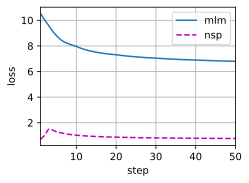

In [11]:
train_bert(train_iter, net, loss, len(vocab), devices, 50)

## 用BERT表示文本

在预训练BERT之后，我们可以用它来表示单个文本、文本对或其中的任何词元。下面的函数返回`tokens_a`和`tokens_b`中所有词元的BERT（`net`）表示。


In [12]:
def get_bert_encoding(net, tokens_a, tokens_b=None):
    tokens, segments = d2l.get_tokens_and_segments(tokens_a, tokens_b)
    token_ids = torch.tensor(vocab[tokens], device=devices[0]).unsqueeze(0)
    segments = torch.tensor(segments, device=devices[0]).unsqueeze(0)
    valid_len = torch.tensor(len(tokens), device=devices[0]).unsqueeze(0)
    encoded_X, _, _ = net(token_ids, segments, valid_len)
    return encoded_X

考虑“a crane is flying”这句话。回想一下 :numref:`subsec_bert_input_rep`中讨论的BERT的输入表示。插入特殊标记“&lt;cls&gt;”（用于分类）和“&lt;sep&gt;”（用于分隔）后，BERT输入序列的长度为6。因为零是“&lt;cls&gt;”词元，`encoded_text[:, 0, :]`是整个输入语句的BERT表示。为了评估一词多义词元“crane”，我们还打印出了该词元的BERT表示的前三个元素。


In [13]:
tokens_a = ['a', 'crane', 'is', 'flying']
encoded_text = get_bert_encoding(net, tokens_a)
# 词元：'<cls>','a','crane','is','flying','<sep>'
encoded_text_cls = encoded_text[:, 0, :]
encoded_text_crane = encoded_text[:, 2, :]
encoded_text.shape, encoded_text_cls.shape, encoded_text_crane[0][:3]

(torch.Size([1, 6, 128]),
 torch.Size([1, 128]),
 tensor([1.0007, 0.6988, 0.0043], device='cuda:0', grad_fn=<SliceBackward0>))

现在考虑一个句子“a crane driver came”和“he just left”。类似地，`encoded_pair[:, 0, :]`是来自预训练BERT的整个句子对的编码结果。注意，多义词元“crane”的前三个元素与上下文不同时的元素不同。这支持了BERT表示是上下文敏感的。


In [14]:
tokens_a, tokens_b = ['a', 'crane', 'driver', 'came'], ['he', 'just', 'left']
encoded_pair = get_bert_encoding(net, tokens_a, tokens_b)
# 词元：'<cls>','a','crane','driver','came','<sep>','he','just',
# 'left','<sep>'
encoded_pair_cls = encoded_pair[:, 0, :]
encoded_pair_crane = encoded_pair[:, 2, :]
encoded_pair.shape, encoded_pair_cls.shape, encoded_pair_crane[0][:3]

(torch.Size([1, 10, 128]),
 torch.Size([1, 128]),
 tensor([ 0.5613, -0.4083,  0.8542], device='cuda:0', grad_fn=<SliceBackward0>))

在 :numref:`chap_nlp_app`中，我们将为下游自然语言处理应用微调预训练的BERT模型。

## 小结

* 原始的BERT有两个版本，其中基本模型有1.1亿个参数，大模型有3.4亿个参数。
* 在预训练BERT之后，我们可以用它来表示单个文本、文本对或其中的任何词元。
* 在实验中，同一个词元在不同的上下文中具有不同的BERT表示。这支持BERT表示是上下文敏感的。

## 练习

1. 在实验中，我们可以看到遮蔽语言模型损失明显高于下一句预测损失。为什么？
2. 将BERT输入序列的最大长度设置为512（与原始BERT模型相同）。使用原始BERT模型的配置，如$\text{BERT}_{\text{LARGE}}$。运行此部分时是否遇到错误？为什么？


[Discussions](https://discuss.d2l.ai/t/5743)
